<a href="https://colab.research.google.com/github/prasukjain3/ISPA-Case-Study-011/blob/main/RA2211047010011_ISPA_Case_Study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Customer Churn Prediction - Model Development, Validation, and Deployment

Objective:
The objective of this assignment is to develop, validate, compare, and deploy a predictive model that identifies customers likely to churn. Students will apply statistical inference and predictive modeling concepts - including model validation, comparison, evaluation, and deployment - using a real-world dataset.

Case Background:
Customer churn represents one of the biggest challenges for telecom and subscription-based
industries. Losing customers increases operational costs and reduces profits. As a Data Analyst,
your task is to build a customer churn prediction model using publicly available datasets, validate its
accuracy, and design a framework for deployment and future model updates.

/tmp/ipython-input-2428655987.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='Churn', data=df, palette='viridis')


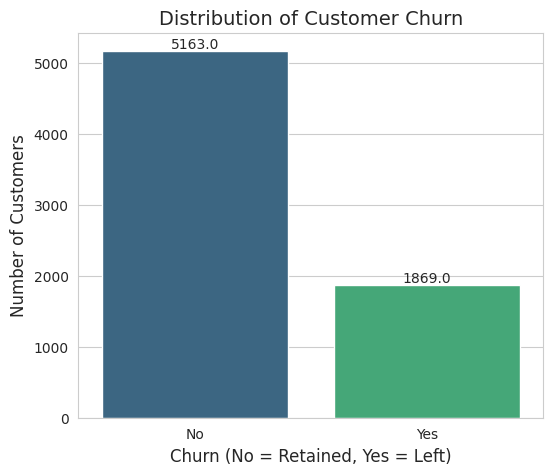

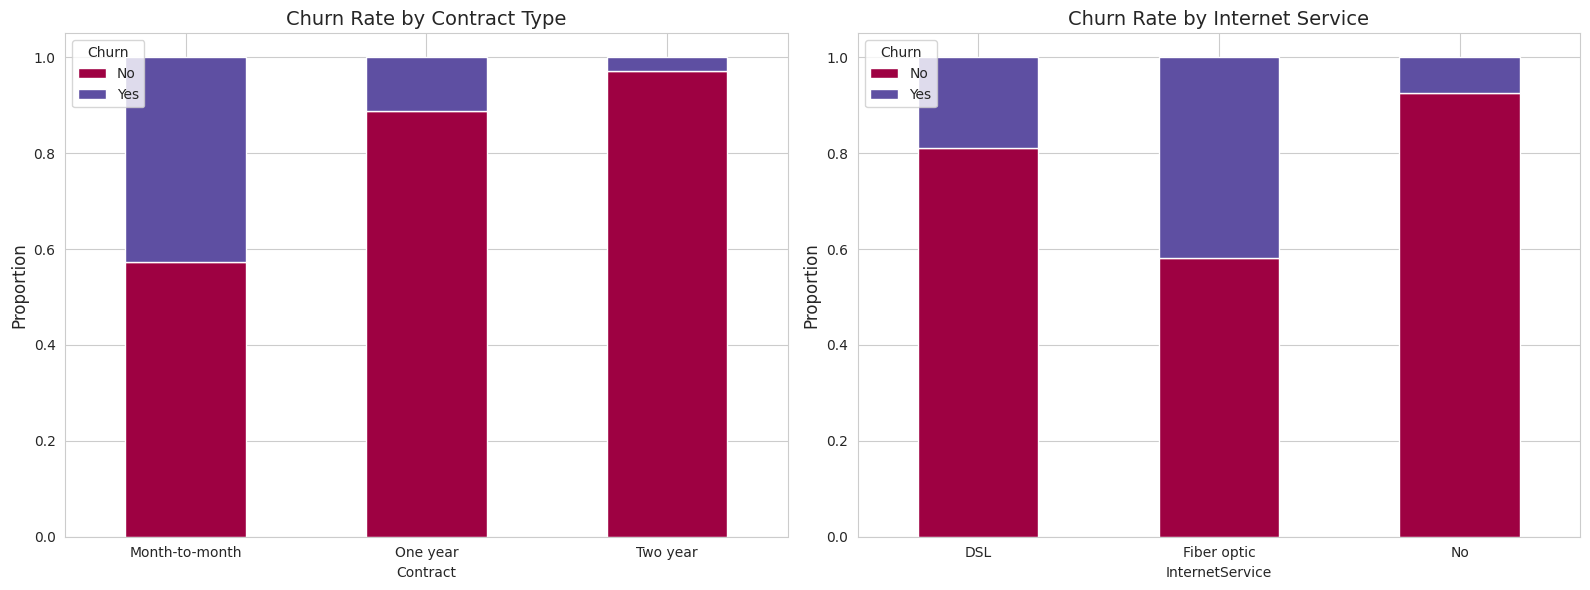

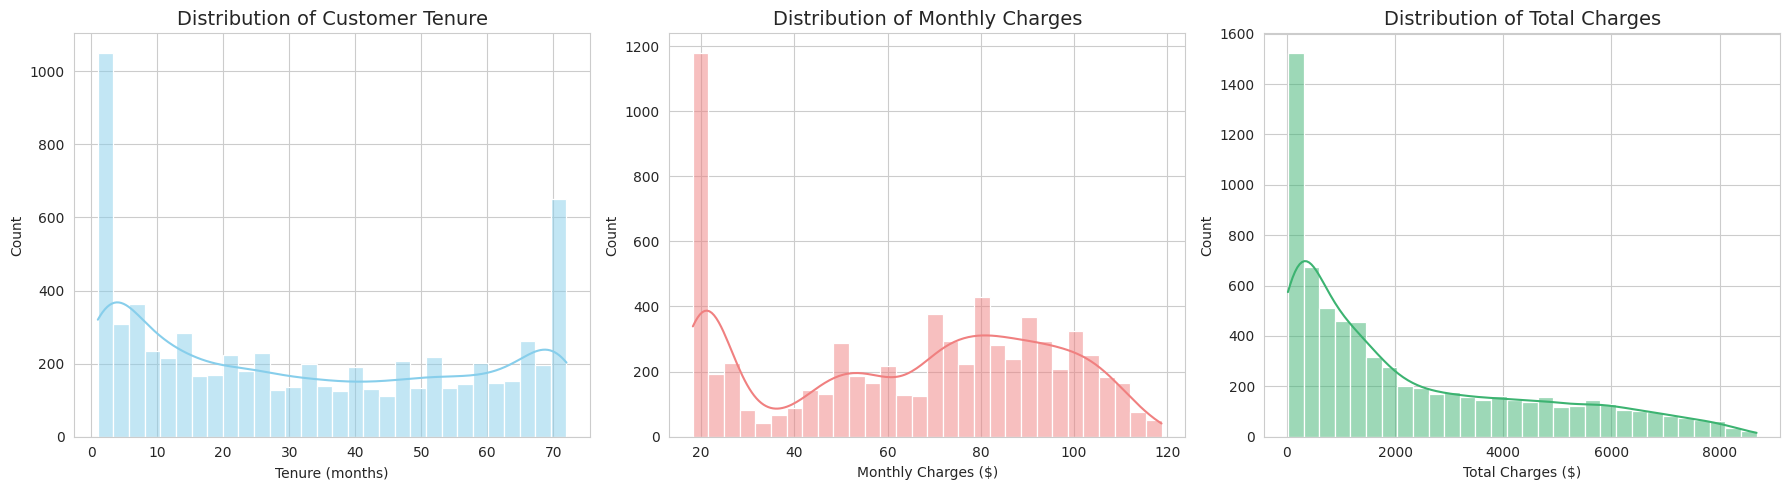


--- CHAID-like Decision Tree Rules (max_depth=5) ---

|--- Contract_Month-to-month <= 0.50
|   |--- MonthlyCharges <= 0.95
|   |   |--- OnlineSecurity_No <= 0.50
|   |   |   |--- PaymentMethod_Electronic check <= 0.50
|   |   |   |   |--- Contract_One year <= 0.50
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- Contract_One year >  0.50
|   |   |   |   |   |--- class: 0
|   |   |   |--- PaymentMethod_Electronic check >  0.50
|   |   |   |   |--- TechSupport_No <= 0.50
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- TechSupport_No >  0.50
|   |   |   |   |   |--- class: 0
|   |   |--- OnlineSecurity_No >  0.50
|   |   |   |--- tenure <= -0.28
|   |   |   |   |--- gender_Female <= 0.50
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- gender_Female >  0.50
|   |   |   |   |   |--- class: 0
|   |   |   |--- tenure >  -0.28
|   |   |   |   |--- PaymentMethod_Mailed check <= 0.50
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- PaymentMethod_Mailed check >  0.50
| 

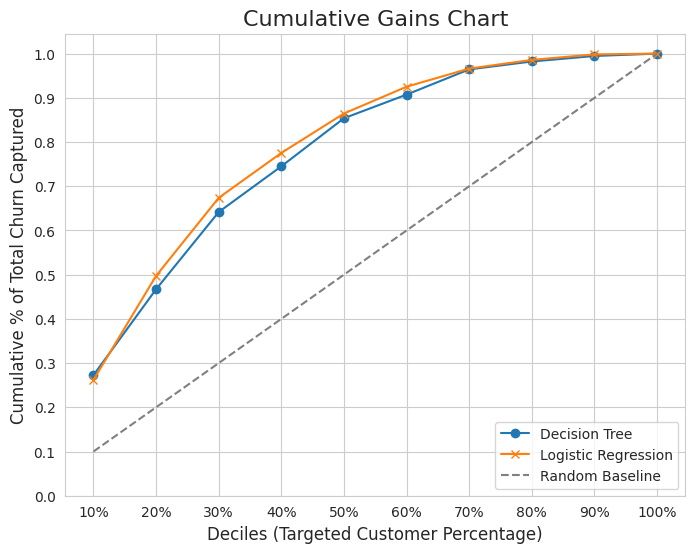

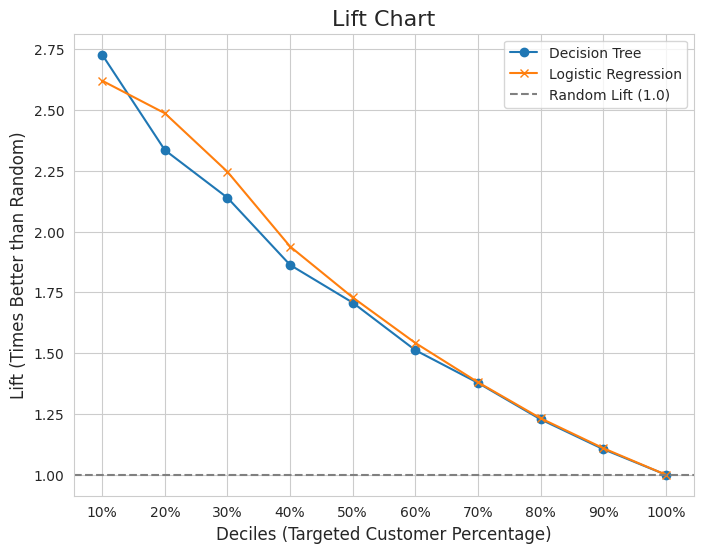

In [ ]:
# 📊 Telco Customer Churn Prediction – Complete Analysis and Modeling
# Tasks:
# 1️⃣ Data Preparation and EDA
# 2️⃣ Model Development and Rule Induction (CHAID-like Decision Tree)
# 3️⃣ Model Comparison and Evaluation (Accuracy, ROC-AUC, Gains & Lift Charts)

# -------------------------------------------------------
# 📦 Import Required Libraries
# -------------------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score

# -------------------------------------------------------
# 🧹 1. Data Preparation and Introduction (Task 1)
# -------------------------------------------------------

# Load the dataset
file_name = "Telco Customer Churn Dataset.csv"
df = pd.read_csv(file_name)

# Handle missing TotalCharges (spaces → NaN) and convert to numeric
df['TotalCharges'] = df['TotalCharges'].replace(' ', np.nan)
df.dropna(subset=['TotalCharges'], inplace=True)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'])

# Drop customerID column (not useful for prediction)
df.drop('customerID', axis=1, inplace=True)

# Encode target variable: Yes → 1, No → 0
df['Churn_Encoded'] = df['Churn'].map({'Yes': 1, 'No': 0})
X = df.drop(['Churn', 'Churn_Encoded'], axis=1)
y = df['Churn_Encoded']

# Split data (70% training, 30% testing)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Identify categorical and numerical features
categorical_features = X.select_dtypes(include=['object']).columns.tolist()
categorical_features.append('SeniorCitizen')
numerical_features = ['tenure', 'MonthlyCharges', 'TotalCharges']

# -------------------------------------------------------
# 📈 Exploratory Data Analysis (EDA) – Task 1
# -------------------------------------------------------

sns.set_style("whitegrid")

# (1) Plot – Churn Distribution
# Shows how many customers stayed (No) vs left (Yes)
plt.figure(figsize=(6, 5))
ax = sns.countplot(x='Churn', data=df, palette='viridis')
plt.title('Distribution of Customer Churn', fontsize=14)
plt.xlabel('Churn (No = Retained, Yes = Left)', fontsize=12)
plt.ylabel('Number of Customers', fontsize=12)

# Annotate counts on bars
for p in ax.patches:
    ax.annotate(f'{p.get_height()}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')
plt.show()

# (2) Plot – Churn Rate by Contract Type & Internet Service
# Helps identify which customer categories churn more often
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Contract Type vs Churn
pd.crosstab(df['Contract'], df['Churn'], normalize='index') \
    .plot(kind='bar', stacked=True, ax=axes[0], colormap='Spectral')
axes[0].set_title('Churn Rate by Contract Type', fontsize=14)
axes[0].set_ylabel('Proportion', fontsize=12)
axes[0].tick_params(axis='x', rotation=0)

# Internet Service Type vs Churn
pd.crosstab(df['InternetService'], df['Churn'], normalize='index') \
    .plot(kind='bar', stacked=True, ax=axes[1], colormap='Spectral')
axes[1].set_title('Churn Rate by Internet Service', fontsize=14)
axes[1].set_ylabel('Proportion', fontsize=12)
axes[1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

# (3) Plot – Distribution of Numerical Features
# Shows customer tenure, monthly and total charges distribution
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.histplot(df['tenure'], bins=30, kde=True, ax=axes[0], color='skyblue')
axes[0].set_title('Distribution of Customer Tenure', fontsize=14)
axes[0].set_xlabel('Tenure (months)')

sns.histplot(df['MonthlyCharges'], bins=30, kde=True, ax=axes[1], color='lightcoral')
axes[1].set_title('Distribution of Monthly Charges', fontsize=14)
axes[1].set_xlabel('Monthly Charges ($)')

sns.histplot(df['TotalCharges'], bins=30, kde=True, ax=axes[2], color='mediumseagreen')
axes[2].set_title('Distribution of Total Charges', fontsize=14)
axes[2].set_xlabel('Total Charges ($)')

plt.tight_layout()
plt.show()

# -------------------------------------------------------
# 🌳 2. Model Development & Rule Induction (Task 2)
# -------------------------------------------------------

# Preprocessing (OHE for categorical, scaling for numeric)
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', StandardScaler(), numerical_features)
    ],
    remainder='passthrough'
)

# Decision Tree (CHAID-like)
dt_model = DecisionTreeClassifier(max_depth=5, random_state=42, criterion='gini')
dt_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', dt_model)
])
dt_pipeline.fit(X_train, y_train)

# Extract readable rules from Decision Tree
ohe_feature_names = dt_pipeline.named_steps['preprocessor'] \
                        .named_transformers_['cat'] \
                        .get_feature_names_out(categorical_features)
all_feature_names = list(ohe_feature_names) + numerical_features

tree_rules = export_text(
    dt_pipeline.named_steps['classifier'],
    feature_names=all_feature_names,
    decimals=2,
    max_depth=5
)
print("\n--- CHAID-like Decision Tree Rules (max_depth=5) ---\n")
print(tree_rules)

# -------------------------------------------------------
# ⚖️ 3. Model Comparison and Evaluation (Task 3)
# -------------------------------------------------------

# Logistic Regression model
lr_model = LogisticRegression(solver='liblinear', random_state=42)
lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', lr_model)
])
lr_pipeline.fit(X_train, y_train)

# Predictions and probabilities
y_prob_dt = dt_pipeline.predict_proba(X_test)[:, 1]
y_prob_lr = lr_pipeline.predict_proba(X_test)[:, 1]
y_pred_dt = dt_pipeline.predict(X_test)
y_pred_lr = lr_pipeline.predict(X_test)

# Compute Accuracy and ROC-AUC for both models
accuracy_dt = accuracy_score(y_test, y_pred_dt)
accuracy_lr = accuracy_score(y_test, y_pred_lr)
roc_auc_dt = roc_auc_score(y_test, y_prob_dt)
roc_auc_lr = roc_auc_score(y_test, y_prob_lr)

print("\n--- Model Comparison: Accuracy and ROC-AUC ---")
print(f"Decision Tree Accuracy: {accuracy_dt:.4f}")
print(f"Logistic Regression Accuracy: {accuracy_lr:.4f}")
print(f"Decision Tree ROC-AUC: {roc_auc_dt:.4f}")
print(f"Logistic Regression ROC-AUC: {roc_auc_lr:.4f}")

# -------------------------------------------------------
# 📊 Gains and Lift Chart Visualization
# -------------------------------------------------------

# Function to calculate data for Gains and Lift charts
def calculate_lift_gains(y_true, y_probas):
    df_eval = pd.DataFrame({'true': y_true, 'proba': y_probas})
    df_eval = df_eval.sort_values(by='proba', ascending=False).reset_index(drop=True)
    df_eval['decile'] = pd.qcut(df_eval.index, q=10, labels=False, duplicates='drop')
    df_eval['decile'] = df_eval['decile'].apply(lambda x: 10 - x)
    total_churn = df_eval['true'].sum()
    gains = df_eval.groupby('decile')['true'].sum().sort_index(ascending=False).cumsum()
    gains_percent = gains / total_churn
    deciles_list = np.arange(1, len(gains_percent) + 1)
    baseline_percent = deciles_list / len(gains_percent)
    lift = gains_percent / baseline_percent
    return deciles_list, gains_percent.values, baseline_percent, lift.values

# Calculate lift/gains for both models
deciles, gains_dt, baseline, lift_dt = calculate_lift_gains(y_test.values, y_prob_dt)
_, gains_lr, _, lift_lr = calculate_lift_gains(y_test.values, y_prob_lr)

# (1) Plot – Cumulative Gains Chart
# Shows what percentage of churners are captured as we target top deciles
plt.figure(figsize=(8, 6))
plt.plot(deciles, gains_dt, label='Decision Tree', marker='o')
plt.plot(deciles, gains_lr, label='Logistic Regression', marker='x')
plt.plot(deciles, baseline, label='Random Baseline', linestyle='--', color='gray')
plt.title('Cumulative Gains Chart', fontsize=16)
plt.xlabel('Deciles (Targeted Customer Percentage)', fontsize=12)
plt.ylabel('Cumulative % of Total Churn Captured', fontsize=12)
plt.xticks(deciles, [f'{i*10}%' for i in deciles])
plt.yticks(np.arange(0, 1.1, 0.1))
plt.grid(True)
plt.legend(loc='lower right')
plt.show()

# (2) Plot – Lift Chart
# Shows how much better the model performs compared to random targeting
plt.figure(figsize=(8, 6))
plt.plot(deciles, lift_dt, label='Decision Tree', marker='o')
plt.plot(deciles, lift_lr, label='Logistic Regression', marker='x')
plt.axhline(y=1, color='gray', linestyle='--', label='Random Lift (1.0)')
plt.title('Lift Chart', fontsize=16)
plt.xlabel('Deciles (Targeted Customer Percentage)', fontsize=12)
plt.ylabel('Lift (Times Better than Random)', fontsize=12)
plt.xticks(deciles, [f'{i*10}%' for i in deciles])
plt.grid(True)
plt.legend(loc='upper right')
plt.show()
